In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

np.random.seed(14753)

# From the SK model to matrix factorization

In this notebook we will study the (planted) SK model using AMP and its state evolution. We will also show how we can easily generalize this approach to more complicated models.

## The planted SK model

We start from the following generative model, which defines $P ({\bf x},  J)$


$$ x_i \sim \frac12 \, \delta(x_i - 1) + \frac12 \, \delta (x_i + 1), \quad i \in [N]   $$

$$  J_{ij} \sim \mathcal{N} (x_i x_j, \sigma^2), \quad (i, j) \in [N]^2 $$ 

Our objective is to estimate ${\bf x}$ given the knowledge of $J$. For that we use Bayes theorem to write the *posterior distribution* $P ({\bf x} | J)$

$$P({\bf x} | J) = \frac{P({\bf x}, J)}{P (J)} \propto \prod_{ij} P(J_{ij} | x_i, x_j) \, \prod_i P_0 (x_i) \propto \exp \bigg\{\beta \sum_{ij} J_{ij} x_i x_j\bigg\}$$

for $\beta = 1 / \sigma^2$. Note that this distribution is quite similar to the one appearing in the Sherrington-Kirkpatrick model; the distribution $P (J)$ is however quite peculiar, as the $J$'s are generated from a particular, *planted* configuration.

We shall use as estimate the MMSE (minimum mean squared error) -- in other words, the mean of $P({\bf x} | J)$. We cannot compute it analytically though, and performing the exact numerical computation would take a very long time! We must thus resort to approximations.

Let us first write a function to sample an instance $\{{\bf x}, J\}$ for us: it first samples ${\bf x} \sim U(\{-1, +1\}^N)$, then generates $J$ by setting $J_{ij} = x_i x_j + \mathcal{N} (0, \sigma^2_{ij})$.

In [12]:
def sample_instance(size_x, var_noise):
    """Sample {x, J} from P(x, J)"""
    
    # Sample x from U({+1, -1}^N)
    x0 = np.random.choice([+1, -1], size_x)
    
    # Generate J = xx^T / sqrt(N) + noise
    W = np.outer(x0, x0) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_x, size_x)
    noise = np.tril(noise) + np.tril(noise).T  # make noise symmetric
    
    J = W + noise
    np.fill_diagonal(J, 0)  # set diagonal elements to zero

    return x0, J

We test this function below and see if its output makes sense.

In [14]:
x0, J = sample_instance(size_x= 1000,
                        var_noise=0.1)

print(x0)
print(x0.shape)
print(J)
print(J.shape)

[-1  1 -1  1  1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1
 -1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1 -1  1  1 -1  1
  1 -1  1  1  1 -1 -1 -1  1 -1  1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1 -1
  1 -1 -1  1 -1  1  1  1  1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1  1
  1  1 -1  1  1  1 -1  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1
 -1  1  1  1 -1 -1 -1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1 -1 -1 -1 -1
  1  1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1
  1  1  1  1  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1  1 -1  1 -1  1 -1  1  1  1  1  1  1 -1 -1  1  1 -1  1  1  1  1  1
  1 -1  1  1  1  1  1 -1 -1 -1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1  1
 -1 -1  1 -1 -1  1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1  1 -1  1 -1  1
 -1  1 -1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1 -1

## Approximate message-passing for low-rank matrix factorization

We now implement AMP. For the class of models $J = XX^T + \xi$, with $X \in \mathbb{R}^{N \times R}$, the (simplified) AMP iteration is given by

$$
\begin{aligned}
A^t &= \frac{1}{\sigma^2} (\mathbb{E}^t X)^T \mathbb{E}^t X \\
B^t &= \frac{1}{\sqrt{N} \sigma^2} J \, \mathbb{E}^t X - \frac{1}{\sigma^2} \mathbb{E}^{t - 1} X \langle \operatorname{Var}^t X \rangle
\end{aligned}
$$

with mean and variances computed with respect to $Q^t \equiv Q ({\bf x}; A^{t - 1}, {\bf B}^{t - 1}) \propto P_0({\bf x}) \, e^{-\frac{1}{2} {\bf x}^T A^{t-1} {\bf x} + {\bf B}^{t - 1} \cdot {\bf x}}$. In our case, $x$ is Rademacher so the mean is given by $\tanh(B)$, and the variance by $1 - \tanh^2(B)$. Putting these together yields for the mean ${\bf m}$

$$
{\bf m}^{t + 1} = \tanh\left( \frac{\beta}{\sqrt{N}} J {\bf m}^t - \beta \, {\bf m}^{t - 1} \, \langle 1 - {\bf m}^{t} \cdot {\bf m}^t \rangle \right)
$$

which can be recognized as the TAP equations.

Once again, our objective is to compute the MMSE estimate $\hat{\bf x}_{\rm MMSE} ({\bf J})$, which is given by the mean of $P({\bf x} | J)$. We will approximate this quantity by the mean $\mathbb{E} X$ provided by AMP upon convergence; in fact, this is a very good approximation, which becomes exact in the large $N$ limit.

**Exercise 1:** fill the MSE computation in the code below!

In [24]:
def iterate_amp(J, var_noise, x0=None, max_iter=10000, tol=1e-8, verbose=1):
    """Iterate AMP to solve J = xx^T, w/ x Rademacher"""
    
    # Some pre-processing
    size_x = J.shape[0]
    
    # Initialize variables
    B = np.zeros(size_x)
    m = np.random.rand(size_x)
    m_old = np.zeros(size_x)
    
    for t in range(max_iter):
        
        # Perform iteration
        B = (J.dot(m) / np.sqrt(size_x) - m_old * np.mean(1 - m ** 2)) / var_noise
        m_old = np.copy(m)
        m = np.tanh(B)
         
        # Compute metrics
        diff = np.mean(np.abs(m - m_old))
        mse = np.mean((m - x0) ** 2) if x0 is not None else 0
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g; mse = %g" % (t, diff, mse))
        
        # Check for convergence
        if diff < tol:
            break
            
    return m

Let's check if our implementation works. We will use the data generated before. Note that we need to pass the correct value of the noise -- if we didn't know, there are techniques we could use to learn it.

In [25]:
iterate_amp(J= J, var_noise= 0.1, x0= x0)

t = 0, diff = 0.774089; mse = 1.55374
t = 1, diff = 0.857219; mse = 1.60638
t = 2, diff = 0.914687; mse = 1.45886
t = 3, diff = 0.919051; mse = 1.12688
t = 4, diff = 0.757757; mse = 0.392371
t = 5, diff = 0.281454; mse = 0.0153821
t = 6, diff = 0.0162218; mse = 0.000563549
t = 7, diff = 0.000374279; mse = 0.000514451
t = 8, diff = 6.26341e-05; mse = 0.000566104
t = 9, diff = 3.48467e-06; mse = 0.000566657
t = 10, diff = 8.38495e-07; mse = 0.000565703
t = 11, diff = 7.30818e-08; mse = 0.000565699
t = 12, diff = 1.63097e-08; mse = 0.000565714
t = 13, diff = 8.92896e-10; mse = 0.000565714


array([-0.99999993,  1.        , -0.99999988,  1.        ,  1.        ,
        1.        , -0.99999989,  0.99999995, -1.        , -0.99999999,
        1.        , -1.        , -1.        , -0.99955767, -0.99998639,
       -0.9999932 ,  0.99999986, -0.9999311 , -1.        , -0.99999997,
        0.99999997, -1.        , -0.99999989, -0.99999999, -0.99999941,
        1.        ,  0.99999998,  0.99927636,  0.99999999, -1.        ,
        1.        ,  1.        , -0.8613616 , -1.        , -0.99998751,
       -0.99999994, -0.9999993 ,  0.99999638,  1.        , -0.99983983,
       -0.99995833,  1.        ,  0.99999999, -0.99999954,  1.        ,
        0.99999926, -0.99999999,  1.        ,  1.        , -1.        ,
        0.99999998,  1.        ,  1.        , -1.        , -0.99999575,
       -0.99999999,  1.        , -1.        ,  0.99999997,  1.        ,
       -0.99999932,  0.99999998, -1.        ,  0.9999998 ,  1.        ,
        0.99999993,  0.99999904, -1.        , -1.        ,  1.  

Good, it seems to work! Now let's briefly perform an experiment to see what's the error we get for different values of noise $\sigma^2$.

In [27]:
def run_experiment(noise_vars, size_x):
    """Compute overlap obtained by AMP using different noise variances"""
    
    overlaps = np.zeros(len(noise_vars))
    
    # For each variance in noise_vars, sample new instance and run AMP
    for i, var in enumerate(noise_vars):
        x0, J = sample_instance(size_x=size_x, var_noise=var)
        m = iterate_amp(J, var_noise=var, verbose=0)
        
        overlaps[i] = np.abs(np.mean(m * x0))
        print("noise_var = %g, overlap = %g" % (var, overlaps[i]))
        
    return overlaps

In [28]:
noise_vars = np.arange(0.1, 2.0, 0.1)

overlaps = run_experiment(noise_vars= noise_vars, 
                          size_x= 2000)

noise_var = 0.1, overlap = 0.997158
noise_var = 0.2, overlap = 0.954814
noise_var = 0.3, overlap = 0.850767
noise_var = 0.4, overlap = 0.774182
noise_var = 0.5, overlap = 0.628735
noise_var = 0.6, overlap = 0.500274
noise_var = 0.7, overlap = 0.35377
noise_var = 0.8, overlap = 0.217723
noise_var = 0.9, overlap = 0.0103067
noise_var = 1, overlap = 0.000204884
noise_var = 1.1, overlap = 0.105767
noise_var = 1.2, overlap = 3.76456e-10
noise_var = 1.3, overlap = 3.04344e-11
noise_var = 1.4, overlap = 1.90682e-08
noise_var = 1.5, overlap = 4.92728e-10
noise_var = 1.6, overlap = 1.01482e-10
noise_var = 1.7, overlap = 1.83835e-10
noise_var = 1.8, overlap = 3.19161e-10
noise_var = 1.9, overlap = 2.11312e-10


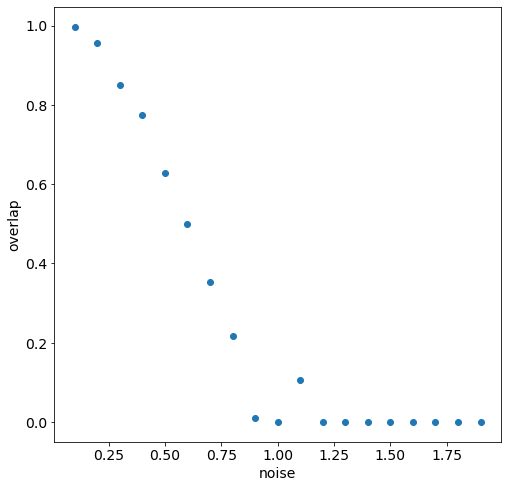

In [29]:
plt.plot(noise_vars, overlaps, 'o')
plt.ylabel('overlap')
plt.xlabel('noise')
plt.show()

Apparently at $\sigma^2 \approx 1$ the algorithm ceases to provide us any meaningful output, that is, we are no better using it instead of flipping a coin.

## Predicting the performance of AMP w/ state evolution

We can determine analytically what is the performance of AMP for each value of $\sigma^2$, by mean of the so-called state evolution equations. For the model above, it consists in determining the fixed points of

$$
m^{t + 1} = \int Dz \, \tanh(\sqrt{m^t / \sigma^2} z + m^t / \sigma^2)
$$

where $m$ gives the overlap between the planted configuration and our estimate. More generally, for arbitrary prior $P_0 ({\bf x})$ and $R > 1$

$$
M^{t + 1} = \int D{\bf x} \, P_0 ({\bf x}) \, \int D{\bf z} \, \hat{X} (M^t / \sigma^2, M^t / \sigma^2 \, {\bf x} + \sqrt{M^t / \sigma^2} {\bf z}) \cdot {\bf x}
$$

where $\hat{X} (A, B) = \mathbb{E}_{Q(x; A, B)} X$.

In [57]:
from scipy.integrate import quad

def iterate_se(var_noise, max_iter=250, tol=1e-11, verbose=1):
    '''Iterate state evolution associated to AMP implementation above'''
    
    # Define function to be integrated at each step
    f = lambda x: lambda z: np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi) * \
            np.tanh(np.sqrt(x) * z + x)
    
    m = 1e-3
    
    for t in range(max_iter):
        m_old = m
        m = quad(f(m / var_noise), -10, 10)[0]
        
        diff = np.abs(m - m_old)
        if verbose:
            print('t = %d, diff = %g; m = %g' % (t, diff, m))
            
        if(diff < tol):
            break
    
    return m

Let's see if this works.

In [58]:
iterate_se(var_noise= 0.1)

t = 0, diff = 0.00890162; m = 0.00990162
t = 1, diff = 0.0806142; m = 0.0905158
t = 2, diff = 0.428603; m = 0.519118
t = 3, diff = 0.446399; m = 0.965517
t = 4, diff = 0.0315761; m = 0.997093
t = 5, diff = 0.000457241; m = 0.99755
t = 6, diff = 6.05676e-06; m = 0.997556
t = 7, diff = 8.0128e-08; m = 0.997557
t = 8, diff = 1.06004e-09; m = 0.997557
t = 9, diff = 1.40234e-11; m = 0.997557
t = 10, diff = 1.85518e-13; m = 0.997557


0.9975565759008704

Good! We can now compare the overlap predicted by the state evolution to that we obtained using AMP.

In [59]:
# Compute predicted overlaps for different values of noise variance
pred_vars = np.linspace(0.01, 2, 100)

pred_overlaps = [iterate_se(var_noise= var, verbose=0) for var in pred_vars]

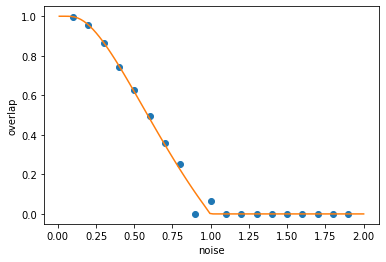

In [60]:
# Compare final overlap obtained by AMP and state evolution, for each value of noise variance
plt.plot(noise_vars, overlaps, 'o')
plt.plot(pred_vars, pred_overlaps, '-')
plt.ylabel('overlap')
plt.xlabel('noise')
plt.show()

They seem to be in good agreement, apart from finite size problems -- try running it again for large $N$ to confirm that is the case!

**Exercise**: show that for $\sigma^2 > 1$ the trivial solution $m = 0$ is a linearly stable fixed point.

## From $xx^T$ to $XX^T$ and $UV^T$: clustering with GMMs

One can easily generalize the algorithm and analysis above to similar, more complicated models (see [Lesieur et al. 2017](http://iopscience.iop.org/article/10.1088/1742-5468/aa7284/meta)). We now consider the following latent variable model

$$\left\{
\begin{aligned}
    {\bf U}_i &\sim \mathcal{N} (0, I_R) \\
    {\bf V}_j & \sim \frac{1}{R} \sum_{k = 1}^R \delta({\bf V}_j - \mathbb{e}_k) \\
    Y_{ij} &\sim \mathcal{N} ({\bf U}_i \cdot {\bf V}_j, \sigma^2)
\end{aligned}
\right.
$$

which provides a good description of *Gaussian mixture models* or GMMs (see figure below for an example of how this would work in the $R = 2$ case).

![Test](img/cluster.png)

We begin by sampling from the generative model.

In [14]:
def sample_instance(size_u, size_v, rank, var_noise):
    """Sample {U, V, Y} from P(U, V, Y)"""
    
    # Sample U_i from N(0, I_r)
    U = np.random.randn(size_u, rank)
    
    # Sample V_j from uniform distribution over standard basis vectors
    labels = np.random.randint(rank, size=size_v)
    V = np.zeros((size_v, rank))
    V[range(len(V)), labels] = 1
    
    # Generate Y = UV^T / sqrt(N) + noise
    W = U.dot(V.T) / np.sqrt(size_u)
    noise = np.sqrt(var_noise) * np.random.randn(size_u, size_v)
    Y = W + noise
    
    return U, V, Y

Let's see what our data looks like. Note that we'll do something very low-dimensional: $U$ is 2x3, and $V$ is 100x3. In the context of our model that means we have 2 dimensions and 100 samples.

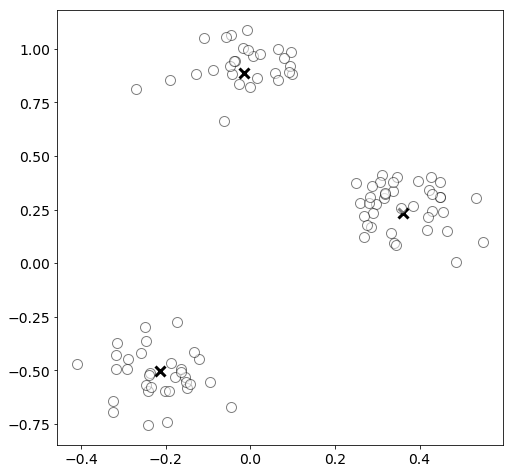

In [15]:
U, V, Y = sample_instance(2, 100, 3, 0.01)
plt.plot(U[0, :] / np.sqrt(len(U)), U[1, :] / np.sqrt(len(U)), "kx", ms=10, mew=3)
plt.plot(Y[0, :], Y[1, :], "ko", mfc="w", ms=10, alpha=0.5)

Our objective here is to perform clustering, i.e. to identify the different groups to which each sample belongs to. We'll do that via AMP.

Let's then implement AMP for the $UV^T$ model.

In [16]:
def iterate_amp(Y, rank, var_noise, x0=None, max_iter=100, tol=1e-7, verbose=1):
    """Iterate AMP to solve Y = UV^T + noise"""
    
    # Some pre-processing
    size_u, size_v = Y.shape
    
    S = Y / (np.sqrt(size_u) * var_noise)
    I = 1 / (size_u * var_noise)
    
    # Initialize variables for U
    A_U = np.ones((rank, rank))
    B_U = np.zeros((size_u, rank))
    a_U = np.random.randn(size_u, rank)
    c_U = np.ones((rank, rank))
    
    # Initialize variables for V
    A_V = np.ones((rank, rank))
    B_V = np.zeros((size_v, rank))
    a_V = np.zeros((size_v, rank))
    c_V = np.ones((rank, rank))
    
    for t in range(max_iter):
        # Perform iteration in V
        B_V = S.T.dot(a_U) - I * a_V.dot(c_U)
        A_V = I * a_U.T.dot(a_U)
        a_Vold = np.copy(a_V)
        a_V, c_V = prior_V(A_V, B_V)
        
        # Perform iteration i U
        B_U = S.dot(a_V) - I * a_U.dot(c_V)
        A_U = I * a_V.T.dot(a_V)
        a_Uold = np.copy(a_U)
        a_U, c_U = prior_U(A_U, B_U)
      
        # Compute metrics
        diff = np.mean(np.abs(a_U - a_Uold))
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g" % (t, diff))
        
        # Check for convergence
        if diff < tol:
            break
            
    return a_U, a_V

We next need to compute the prior functions for $U$ and $V$.

In [17]:
def prior_U(A, B):
    """Prior functions f and f' for Gaussian prior"""
    n, r = B.shape
    a = np.linalg.solve(A + np.eye(r), B.T).T
    c = n * np.linalg.inv(A + np.eye(r))
    return a, c
    
def prior_V(A, B):
    """Prior functions f and f' for uniform prior over standard basis vectors"""
    n, r = B.shape
    
    arg = -.5 * np.diag(A).T + B
    max_arg = np.max(arg, 1)
    exps = np.exp((arg.T - max_arg).T)
    z = np.sum(exps, 1)
    
    a = (exps.T / z).T
    c = np.diag(np.sum(a, 0)) - a.T.dot(a)
    return a, c

We can now run AMP. Our estimate for $U$ will give the position of the centroids, and our estimate for $V$ will give the labels of each data point.

In [18]:
a_U, a_V = iterate_amp(Y, rank=3, var_noise=0.01);

t = 0, diff = 0.565934
t = 1, diff = 0.155269
t = 2, diff = 0.134367
t = 3, diff = 0.0358092
t = 4, diff = 1.0921e-07
t = 5, diff = 1.17603e-13


We will now plot the centroids, and the labels obtained for each data point.

**Exercise 2**: given our estimate for $V$, `a_V`, compute the labels for each point.

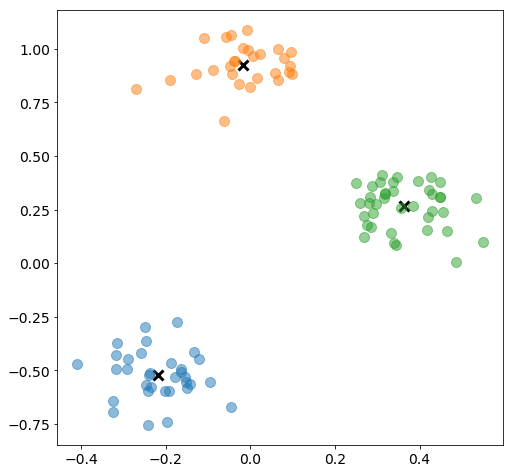

In [19]:
# Plot centroids
plt.plot(a_U[0, :] / np.sqrt(len(a_U)), a_U[1, :] / np.sqrt(len(a_U)), "kx", ms=10, mew=3)

# Plot data points with different colors
labels =
for i in range(3):
    plt.plot(Y[0, labels == i], Y[1, labels == i], "o", ms=10, alpha=0.5)

In [ ]:
# Uncomment the line below to load the solution
#%load exo2.py

## References

1. Zdeborová, Lenka, and Florent Krzakala. "Statistical physics of inference: Thresholds and algorithms." Advances in Physics 65.5 (2016): 453-552.

2. Lesieur, Thibault, Florent Krzakala, and Lenka Zdeborová. "Constrained low-rank matrix estimation: Phase transitions, approximate message passing and applications." Journal of Statistical Mechanics: Theory and Experiment 2017.7 (2017): 073403.

3. Rangan, Sundeep, and Alyson K. Fletcher. "Iterative estimation of constrained rank-one matrices in noise." Information Theory Proceedings (ISIT), 2012 IEEE International Symposium on. IEEE, 2012.

4. Matsushita, Ryosuke, and Toshiyuki Tanaka. "Low-rank matrix reconstruction and clustering via approximate message passing." Advances in Neural Information Processing Systems. 2013.

5. Thouless, David J., Philip W. Anderson, and Robert G. Palmer. "Solution of 'solvable model of a spin glass'." Philosophical Magazine 35.3 (1977): 593-601.